In [1]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
import h5py
import pandas as pd
from astropy.table import Table
from astropy.io import fits

In [2]:
# MgII Simulated Absorbers

# z = 0.5
f1 = h5py.File('spectra_TNG50-1_z0.5_n1000d2-fullbox_DESI_MgII_combined.hdf5')
wave_mgii = f1['wave'] # wavelegnth range same for all files, same as DESI range
tau_2796_05 = f1['tau_MgII_2796'] # optical depth array of the 2796 line
tau_2803_05 = f1['tau_MgII_2803'] # optical depth array of the 2803 line
EW_2796_05 = f1['EW_MgII_2796'] # Equivelent width of the  2796 line
EW_2803_05 = f1['EW_MgII_2803'] # Equivelent width of the  2803 line
print(f1.keys())
# z = 0.7
f2 = h5py.File('spectra_TNG50-1_z0.7_n1000d2-fullbox_DESI_MgII_combined.hdf5')
tau_2796_07 = f2['tau_MgII_2796']
tau_2803_07 = f2['tau_MgII_2803']
EW_2796_07 = f2['EW_MgII_2796']
EW_2803_07 = f2['EW_MgII_2803']
# z = 1.0
f3 = h5py.File('spectra_TNG50-1_z1.0_n1000d2-fullbox_DESI_MgII_combined.hdf5')
tau_2796_10 = f3['tau_MgII_2796']
tau_2803_10 = f3['tau_MgII_2803']
EW_2796_10 = f3['EW_MgII_2796']
EW_2803_10 = f3['EW_MgII_2803']
# z = 1.5
f4 = h5py.File('spectra_TNG50-1_z1.5_n1000d2-fullbox_DESI_MgII_combined.hdf5')
flux_mgii_15 = f4['flux']
tau_2796_15 = f4['tau_MgII_2796']
tau_2803_15 = f4['tau_MgII_2803']
EW_2796_15 = f4['EW_MgII_2796']
EW_2803_15 = f4['EW_MgII_2803']
# z = 2.0
f5 = h5py.File('spectra_TNG50-1_z2.0_n1000d2-fullbox_DESI_MgII_combined.hdf5')
tau_2796_20 = f5['tau_MgII_2796']
tau_2803_20 = f5['tau_MgII_2803']
EW_2796_20 = f5['EW_MgII_2796']
EW_2803_20 = f5['EW_MgII_2803']

<KeysViewHDF5 ['EW_MgII_2796', 'EW_MgII_2803', 'flux', 'ray_dir', 'ray_pos', 'ray_total_dl', 'tau_MgII_2796', 'tau_MgII_2803', 'wave']>


0.0


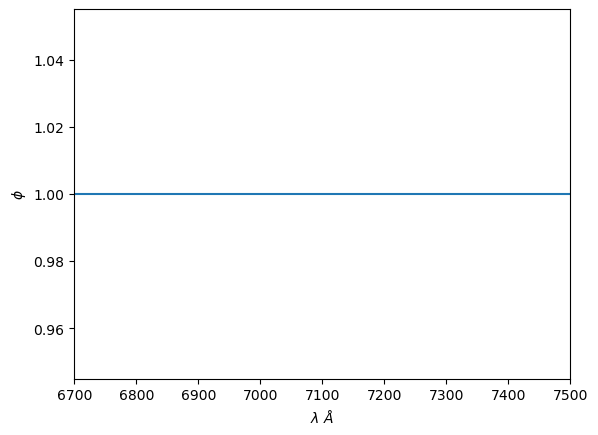

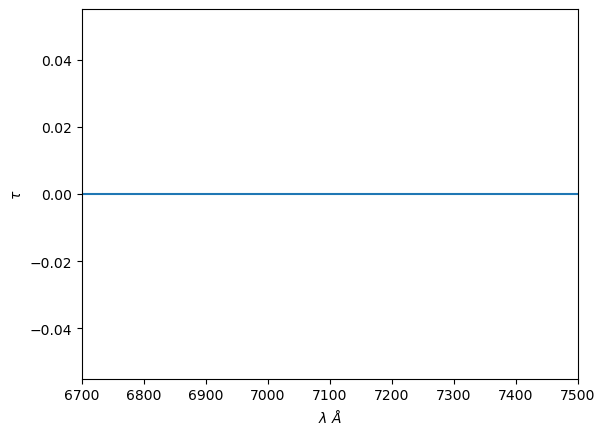

In [5]:
# Plotting Tests
i = 1 # abs index
EW = EW_2796_15[i] 
print(EW)
flux_array = np.array(flux_mgii_15[i])
wave_array = np.array(wave_mgii)
tau_2796_array_15 = np.array(tau_2796_15[i])
tau_2803_array_15 = np.array(tau_2803_15[i])
# tau_2796_array_20 = np.array(tau_2796_20[i])
# tau_2803_array_20 = np.array(tau_2803_20[i])
tau_tot = tau_2796_array_15 + tau_2803_array_15 # + tau_2796_array_20 + tau_2803_array_20 # Total Optical Depth
plt.figure(1)
plt.plot(wave_array, flux_array) # MgII Flux Plot
plt.xlabel('$\lambda\ {\AA}$');
plt.ylabel('$\phi$');
plt.xlim(6700,7500);
plt.figure(2)
plt.plot(wave_array, tau_tot); # MgII Optical Depth Plot
# plt.plot(wave_array, tau_2803_array_15, label='MgII 2803')
# plt.plot(wave_array, tau_2796_array_15, label='MgII 2796')
plt.xlabel('$\lambda\ {\AA}$');
plt.ylabel('$\\tau$');
plt.xlim(6700,7500);
# plt.legend();

In [6]:
# z = 0.5
max_depth = []; ind_array = []; z_avg = []; EW_2796_array = []; EW_2803_array = []
tau_data = []
wave_array = np.array(wave_mgii) # Wavelength Array
tau_data.append(wave_array) # Wavelength Array becomes first row of tau_data
i = 0
rand_abs = np.random.choice(len(tau_2796_05), size=len(tau_2796_05), replace=False) # Select random absorber index
while len(z_avg) < 1000: # Want 1000 absorbers
    j = rand_abs[i]
    this_EW_2796 = EW_2796_05[j]
    if this_EW_2796 > 0.05: # Only consider absorbers with non-zero EW
        tau_2796_array = np.array(tau_2796_05[j])
        tau_2803_array = np.array(tau_2803_05[j])
        tau_tot = tau_2796_array + tau_2803_array # Total Optical Depth
        z_2796 = (wave_array[np.argmax(tau_2796_array)] / 2796.35) - 1 # Redshift from 2796 line
        z_2803 = (wave_array[np.argmax(tau_2803_array)] / 2803.53) - 1 # Redshift from 2803 line
        max_depth.append(np.max(tau_tot))
        ind_array.append(j)
        z_avg.append((z_2796 + z_2803) / 2)
        EW_2796_array.append(this_EW_2796)
        EW_2803_array.append(EW_2803_05[j])
        tau_data.append(tau_tot)
        print(str(len(z_avg)) + ' absorbers')
    i += 1
# Create and Save Catalog and Tau Data    
t = Table()
t['Sim_Index'] = ind_array
t['Z'] = z_avg
t['EW_2796'] = EW_2796_array
t['EW_2803'] = EW_2803_array
t.write('MgII_Simulated_Catalog_z0.5.fits', format='fits', overwrite=True)

tau_sampled = np.vstack(tau_data)
hdu = fits.PrimaryHDU(tau_sampled)
hdu.writeto('Tau_MgII_z0.5.fits', overwrite=True)

1 absorbers
2 absorbers
3 absorbers
4 absorbers
5 absorbers
6 absorbers
7 absorbers


KeyboardInterrupt: 

In [ ]:
# z = 0.7
max_depth = []; ind_array = []; z_avg = []; EW_2796_array = []; EW_2803_array = []
tau_data = []
wave_array = np.array(wave_mgii) # Wavelength Array
tau_data.append(wave_array) # Wavelength Array becomes first row of tau_data
i = 0
rand_abs = np.random.choice(len(tau_2796_07), size=len(tau_2796_07), replace=False) # Select random absorber index
while len(z_avg) < 1000: # Want 1000 absorbers
    j = rand_abs[i]
    this_EW_2796 = EW_2796_07[j]
    if this_EW_2796 > 0.05: # Only consider absorbers with non-zero EW
        tau_2796_array = np.array(tau_2796_07[j])
        tau_2803_array = np.array(tau_2803_07[j])
        tau_tot = tau_2796_array + tau_2803_array # Total Optical Depth
        z_2796 = (wave_array[np.argmax(tau_2796_array)] / 2796.35) - 1 # Redshift from 2796 line
        z_2803 = (wave_array[np.argmax(tau_2803_array)] / 2803.53) - 1 # Redshift from 2803 line
        max_depth.append(np.max(tau_tot))
        ind_array.append(j)
        z_avg.append((z_2796 + z_2803) / 2)
        EW_2796_array.append(this_EW_2796)
        EW_2803_array.append(EW_2803_07[j])
        tau_data.append(tau_tot)
        print(str(len(z_avg)) + ' absorbers')
    i += 1
# Create and Save Catalog and Tau Data    
t = Table()
t['Sim_Index'] = ind_array
t['Z'] = z_avg
t['EW_2796'] = EW_2796_array
t['EW_2803'] = EW_2803_array
t.write('MgII_Simulated_Catalog_z0.7.fits', format='fits', overwrite=True)

tau_sampled = np.vstack(tau_data)
hdu = fits.PrimaryHDU(tau_sampled)
hdu.writeto('Tau_MgII_z0.7.fits', overwrite=True)

In [ ]:
# z = 1.0
max_depth = []; ind_array = []; z_avg = []; EW_2796_array = []; EW_2803_array = []
tau_data = []
wave_array = np.array(wave_mgii) # Wavelength Array
tau_data.append(wave_array) # Wavelength Array becomes first row of tau_data
i = 0
rand_abs = np.random.choice(len(tau_2796_10), size=len(tau_2796_10), replace=False) # Select random absorber index
while len(z_avg) < 1000: # Want 1000 absorbers
    j = rand_abs[i]
    this_EW_2796 = EW_2796_10[j]
    if this_EW_2796 > 0.05: # Only consider absorbers with non-zero EW
        tau_2796_array = np.array(tau_2796_10[j])
        tau_2803_array = np.array(tau_2803_10[j])
        tau_tot = tau_2796_array + tau_2803_array # Total Optical Depth
        z_2796 = (wave_array[np.argmax(tau_2796_array)] / 2796.35) - 1 # Redshift from 2796 line
        z_2803 = (wave_array[np.argmax(tau_2803_array)] / 2803.53) - 1 # Redshift from 2803 line
        max_depth.append(np.max(tau_tot))
        ind_array.append(j)
        z_avg.append((z_2796 + z_2803) / 2)
        EW_2796_array.append(this_EW_2796)
        EW_2803_array.append(EW_2803_10[j])
        tau_data.append(tau_tot)
        print(str(len(z_avg)) + ' absorbers')
    i += 1
# Create and Save Catalog and Tau Data    
t = Table()
t['Sim_Index'] = ind_array
t['Z'] = z_avg
t['EW_2796'] = EW_2796_array
t['EW_2803'] = EW_2803_array
t.write('MgII_Simulated_Catalog_z1.0.fits', format='fits', overwrite=True)

tau_sampled = np.vstack(tau_data)
hdu = fits.PrimaryHDU(tau_sampled)
hdu.writeto('Tau_MgII_z1.0.fits', overwrite=True)

In [ ]:
# z = 1.5
max_depth = []; ind_array = []; z_avg = []; EW_2796_array = []; EW_2803_array = []
tau_data = []
wave_array = np.array(wave_mgii) # Wavelength Array
tau_data.append(wave_array) # Wavelength Array becomes first row of tau_data
i = 0
rand_abs = np.random.choice(len(tau_2796_15), size=len(tau_2796_15), replace=False) # Select random absorber index
while len(z_avg) < 1000: # Want 1000 absorbers
    j = rand_abs[i]
    this_EW_2796 = EW_2796_15[j]
    if this_EW_2796 > 0.05: # Only consider absorbers with non-zero EW
        tau_2796_array = np.array(tau_2796_15[j])
        tau_2803_array = np.array(tau_2803_15[j])
        tau_tot = tau_2796_array + tau_2803_array # Total Optical Depth
        z_2796 = (wave_array[np.argmax(tau_2796_array)] / 2796.35) - 1 # Redshift from 2796 line
        z_2803 = (wave_array[np.argmax(tau_2803_array)] / 2803.53) - 1 # Redshift from 2803 line
        max_depth.append(np.max(tau_tot))
        ind_array.append(j)
        z_avg.append((z_2796 + z_2803) / 2)
        EW_2796_array.append(this_EW_2796)
        EW_2803_array.append(EW_2803_15[j])
        tau_data.append(tau_tot)
        print(str(len(z_avg)) + ' absorbers')
    i += 1
# Create and Save Catalog and Tau Data        
t = Table()
t['Sim_Index'] = ind_array
t['Z'] = z_avg
t['EW_2796'] = EW_2796_array
t['EW_2803'] = EW_2803_array
t.write('MgII_Simulated_Catalog_z1.5.fits', format='fits', overwrite=True)

tau_sampled = np.vstack(tau_data)
hdu = fits.PrimaryHDU(tau_sampled)
hdu.writeto('Tau_MgII_z1.5.fits', overwrite=True)

In [ ]:
# z = 2.0
max_depth = []; ind_array = []; z_avg = []; EW_2796_array = []; EW_2803_array = []
tau_data = []
wave_array = np.array(wave_mgii) # Wavelength Array
tau_data.append(wave_array) # Wavelength Array becomes first row of tau_data
i = 0
rand_abs = np.random.choice(len(tau_2796_20), size=len(tau_2796_20), replace=False) # Select random absorber index
while len(z_avg) < 1000: # Want 1000 absorbers
    j = rand_abs[i]
    this_EW_2796 = EW_2796_20[j]
    if this_EW_2796 > 0.05: # Only consider absorbers with non-zero EW
        tau_2796_array = np.array(tau_2796_20[j])
        tau_2803_array = np.array(tau_2803_20[j])
        tau_tot = tau_2796_array + tau_2803_array # Total Optical Depth
        z_2796 = (wave_array[np.argmax(tau_2796_array)] / 2796.35) - 1 # Redshift from 2796 line
        z_2803 = (wave_array[np.argmax(tau_2803_array)] / 2803.53) - 1 # Redshift from 2803 line
        max_depth.append(np.max(tau_tot))
        ind_array.append(j)
        z_avg.append((z_2796 + z_2803) / 2)
        EW_2796_array.append(this_EW_2796)
        EW_2803_array.append(EW_2803_20[j])
        tau_data.append(tau_tot)
        print(str(len(z_avg)) + ' absorbers')
    i += 1
# Create and Save Catalog and Tau Data        
t = Table()
t['Sim_Index'] = ind_array
t['Z'] = z_avg
t['EW_2796'] = EW_2796_array
t['EW_2803'] = EW_2803_array
t.write('MgII_Simulated_Catalog_z2.0.fits', format='fits', overwrite=True)

tau_sampled = np.vstack(tau_data)
hdu = fits.PrimaryHDU(tau_sampled)
hdu.writeto('Tau_MgII_z2.0.fits', overwrite=True)

In [ ]:
# Max Depth and Redshift Distributions
plt.figure(3)
plt.hist(np.log10(max_depth), bins=20);
plt.xlabel('$\log(\\tau_{max})$');
plt.figure(4)
# plt.hist(z_2796_array, bins=20, alpha=0.5, label='MgII 2796');
# plt.hist(z_2803_array, bins=20, alpha=0.5, label='MgII 2803');
plt.hist(z_avg, bins=20, alpha=0.5, label='Average $z_{abs}$');
plt.xlabel('$z_{abs}$');
plt.legend();